In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import copernicusmarine

## Loading data from copernicus marine

In [4]:
copernicusmarine.login()

username: nhajouji
password: ··········


INFO - 2024-08-05T13:15:24Z - Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.
INFO:copernicus_marine_root_logger:Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.


True

In [2]:
oxygen_dataset_id = 'cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m'
chlorophyl_dataset_id = 'cmems_mod_glo_bgc-pft_anfc_0.25deg_P1M-m'
chemicals_dataset_id = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1M-m'

### Creating the dataframe

In [3]:
chlorophyl_df = copernicusmarine.read_dataframe(
    dataset_id = chlorophyl_dataset_id,
    start_datetime = "2024-01-01",
    end_datetime = "2024-01-02",
)
oxygen_df = copernicusmarine.read_dataframe(
    dataset_id = oxygen_dataset_id,
    start_datetime = "2024-01-01",
    end_datetime = "2024-01-02",
)
chem_df = copernicusmarine.read_dataframe(
    dataset_id = chemicals_dataset_id,
    start_datetime = "2024-01-01",
    end_datetime = "2024-01-02",
)
oxygen_df = oxygen_df.dropna()
chlorophyl_df = chlorophyl_df.dropna()
chem_df = chem_df.dropna()
chem_df['o2'] = oxygen_df.o2
chem_df['chl']=chlorophyl_df.chl
chem_df.reset_index(inplace=True)

Fetching catalog: 100%|██████████| 3/3 [00:22<00:00,  7.38s/it]
INFO - 2024-08-05T14:45:46Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-05T14:45:46Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-05T14:45:50Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-05T14:47:04Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-05T14:47:04Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-05T14:47:07Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-05T14:48:34Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-05T14:48:34Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-05T14:48:36Z - Service was not specified, the default one was selected: "arco-geo-series"


In [4]:
features = ['latitude','depth', 'fe', 'no3', 'po4', 'si','o2']
chem_df = chem_df[features+['chl']]

### Train-test split

In [5]:
chem_train, chem_test = train_test_split(chem_df,train_size = 0.2,shuffle = True, random_state = 1729)

MSE: 0.01
Feature Importances:
latitude: 0.1916704922914505
depth: 0.32136011123657227
fe: 0.06337014585733414
no3: 0.14060074090957642
po4: 0.06847748160362244
si: 0.07773363590240479
o2: 0.13678741455078125


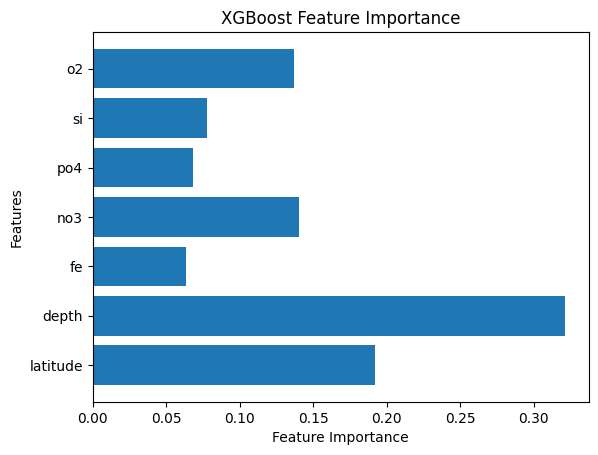

In [13]:
# Create an XGBoost classifier
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

# Train the model
model.fit(chem_train[features], chem_train.chl)

# Make predictions on the test set
y_pred = model.predict(chem_test[features])

# Evaluate the model - using MSE since we're doing regression
mse = mean_squared_error(y_pred=y_pred,y_true = chem_test.chl)
print(f"MSE: {mse:.2f}")

# Explore feature importance
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()


## Grid Search

In [6]:
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error'

)

# Fit the grid search to the training data
grid_search.fit(chem_train[features], chem_train.chl)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params)

# Train the best model
best_model.fit(chem_train[features], chem_train.chl)

# Make predictions on the test set
y_pred_best = best_model.predict(chem_test[features])

# Evaluate the best model
mse_best = mean_squared_error(y_pred=y_pred_best,y_true = chem_test.chl)
print(f"MSE with Best Parameters: {mse_best:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Accuracy with Best Parameters: 0.00


In [7]:
mse_best

0.0023081253460324257

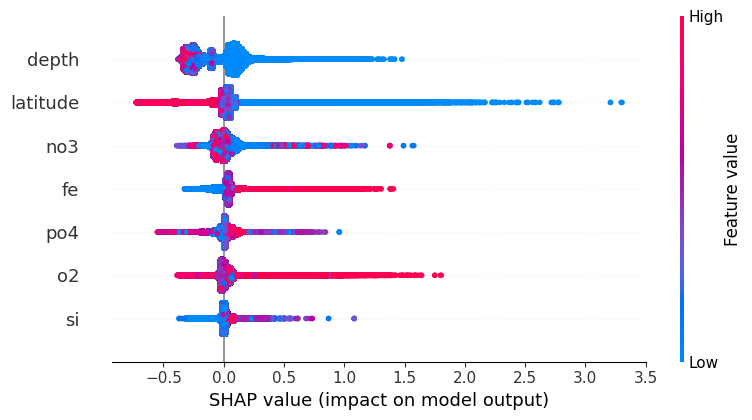

In [11]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(chem_test[features])

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], chem_test[features].iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, chem_test[features])

In [14]:
model = xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1,# Minimum sum of instance weight needed in a child
)

param_grid = {
    'max_depth': [7,11,15],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [200,350,500]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error'

)

# Fit the grid search to the training data
grid_search.fit(chem_train[features], chem_train.chl)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params)

# Train the best model
best_model.fit(chem_train[features], chem_train.chl)

# Make predictions on the test set
y_pred_best = best_model.predict(chem_test[features])

# Evaluate the best model
mse_best = mean_squared_error(y_pred=y_pred_best,y_true = chem_test.chl)
print(f"MSE with Best Parameters: {mse_best:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
MSE with Best Parameters: 0.00


In [15]:
mse_best

0.0005899872091686995

Feature Importances:
latitude: 0.17817825078964233
depth: 0.3430115282535553
fe: 0.08248193562030792
no3: 0.1401195377111435
po4: 0.03406544029712677
si: 0.038665398955345154
o2: 0.18347793817520142


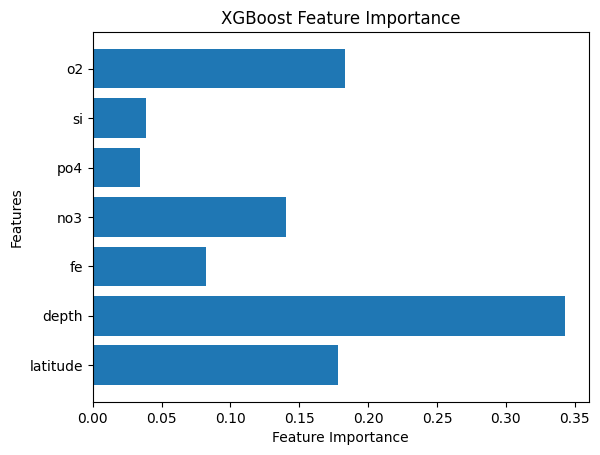

In [16]:
feature_importances = best_model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

I tried the following code but it ran for 24 hours and I gave up.

In [17]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(chem_test[features])

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], chem_test[features].iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, chem_test[features])